## Bootstrap Your Own Latent (BYOL)

https://github.com/sthalles/PyTorch-BYOL

# Installing and importing



In [ ]:
!pip -q install byol-pytorch

In [ ]:
import torch
from byol_pytorch import BYOL

import seaborn as sns

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report , confusion_matrix
import pandas as pd



Code to prevent Colab timeout


function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);

## Import dataset 

In [ ]:
! pip install -q kaggle.
!mkdir ~/.kaggle.
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json.

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q '/content/chest-xray-pneumonia.zip'

100% 2.29G/2.29G [00:30<00:00, 24.5MB/s]



In [ ]:
!kaggle datasets download -d amritpal333/hemorrahge-ct-small
!unzip -q '/content/hemorrahge-ct-small.zip'

 37% 9.00M/24.4M [00:00<00:00, 25.1MB/s]
100% 24.4M/24.4M [00:00<00:00, 45.3MB/s]


In [ ]:
!rm '/content/chest-xray-pneumonia.zip'

In [ ]:
!rm '/content/hemorrahge-ct-small.zip'

# import functions

In [ ]:
def plot_images(inp, title=None):
    plt.figure(figsize = (12,12))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


def train_BYOL_model(model, criterion, optimizer, scheduler = None, num_epochs=25):
    since = time.time()
    train_loss_list = []
    
    for epoch in range(num_epochs):
            model.train()  # Set model to training mode
            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders:
                inputs = inputs.to(device)
                loss = model(inputs)    
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                #model.update_moving_average() # update moving average of target encoder

                running_loss += loss.item() * inputs.size(0)
                #scheduler.step()

            epoch_loss = running_loss / dataset_sizes

            print('Epoch {}/{} -- {} Loss: {:.4f}'.format(epoch, num_epochs - 1 , 'train', epoch_loss))
            train_loss_list.append(epoch_loss)    
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    sns.lineplot( range(len(train_loss_list)), train_loss_list , color = 'red')
    
    return model , train_loss_list 


def predict_BYOL_model(model , dataloaders):

    model.eval()

    since = time.time()
    preds_list = []
    labels_list = []

    z = 0

    with torch.no_grad():
        for inputs, labels in dataloaders:
                    #while z < 10:
                    #inputs = inputs.to(device)
                    loss = model(inputs)
                    #print(loss)
                    _, preds = torch.max(loss, 1)
                        
                    for pred in preds:
                        preds_list.append(pred.detach().numpy())            
                    for label in labels:
                        labels_list.append(label.detach().numpy())
                    z += 1    

    # generate comparison in sklearn - accuracy, precision, f1 score

    print(classification_report(preds, labels , target_names= test_class_names, digits=2))


    # generate and plot confusion matrix
    array = confusion_matrix(preds_list, labels_list)
    df_cm = pd.DataFrame(array)
    plt.figure(figsize = (5,5))
    sns.heatmap(df_cm, annot=True)

    return preds_list , labels_list   

# Hemorrhage - Resnet18

200
['train', 'val']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


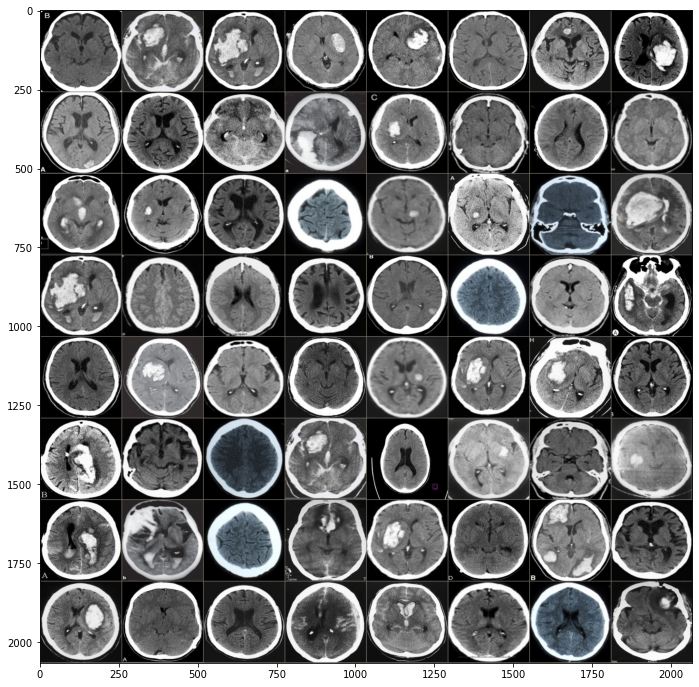

In [ ]:
epochs = 50
batch_size = 64  # using beyond 32 crashes the colab notebook(GPU version)
image_size = 256

data_transforms = transforms.Compose([
        transforms.Resize([256 ,256]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = '/content/Hemorrahage'


image_datasets = datasets.ImageFolder( data_dir,  data_transforms)

dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=batch_size,shuffle=True, num_workers=4)

dataset_sizes = len(image_datasets)

print(dataset_sizes)
class_names = image_datasets.classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


inputs, classes = next(iter(dataloaders))
out = torchvision.utils.make_grid(inputs)
plot_images(out)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0/49 -- train Loss: 2.9229
Epoch 1/49 -- train Loss: 1.9803
Epoch 2/49 -- train Loss: 1.9253
Epoch 3/49 -- train Loss: 1.7425
Epoch 4/49 -- train Loss: 1.6151
Epoch 5/49 -- train Loss: 1.0709
Epoch 6/49 -- train Loss: 0.7939
Epoch 7/49 -- train Loss: 1.5291
Epoch 8/49 -- train Loss: 0.6758
Epoch 9/49 -- train Loss: 0.6372
Epoch 10/49 -- train Loss: 0.5377
Epoch 11/49 -- train Loss: 0.7715
Epoch 12/49 -- train Loss: 0.4811
Epoch 13/49 -- train Loss: 1.0815
Epoch 14/49 -- train Loss: 0.3890
Epoch 15/49 -- train Loss: 0.5875
Epoch 16/49 -- train Loss: 0.3421
Epoch 17/49 -- train Loss: 0.4940
Epoch 18/49 -- train Loss: 0.2029
Epoch 19/49 -- train Loss: 0.3740
Epoch 20/49 -- train Loss: 0.4609
Epoch 21/49 -- train Loss: 0.6734
Epoch 22/49 -- train Loss: 0.4826
Epoch 23/49 -- train Loss: 0.4302
Epoch 24/49 -- train Loss: 0.2917
Epoch 25/49 -- train Loss: 0.5432
Epoch 26/49 -- train Loss: 0.3776
Epoch 27/49 -- train Loss: 0.1281
Epoch 28/49 -- train Loss: 0.5218
Epoch 29/49 -- train Los

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


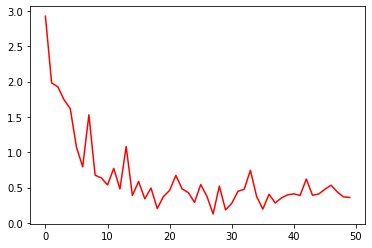

In [ ]:
resnet = models.resnet18(pretrained=True)
#resnet = torch.load('/content/resnet-18_80-epochs/checkpoints/model.pth')

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)

learner = BYOL(resnet,    image_size = image_size ,    hidden_layer = 'avgpool' ,
               use_momentum = False)
learner = learner.to(device)

#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()

optimizer = torch.optim.Adam(learner.parameters(), lr=3e-4)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft , train_loss = train_BYOL_model(learner, criterion, optimizer, num_epochs= 50)

In [ ]:
# save your improved network
torch.save(resnet.state_dict(), './Hemmorahge_resnet_18.pt')

Prediction on Test data

In [ ]:
Trained_resnet = models.resnet18(pretrained=False)
num_ftrs = Trained_resnet.fc.in_features
Trained_resnet.fc = nn.Linear(num_ftrs, 2)

In [ ]:
#model_wts = copy.deepcopy(resnet.state_dict())
model_wts = torch.load('/content/Hemmorahge_resnet_18.pt')

Trained_resnet.load_state_dict(model_wts)
#Trained_resnet.to(device)

<All keys matched successfully>

48
['Hemorrhage', 'Normal']
              precision    recall  f1-score   support

  Hemorrhage       0.46      0.41      0.43        27
      Normal       0.33      0.38      0.36        21

    accuracy                           0.40        48
   macro avg       0.40      0.39      0.39        48
weighted avg       0.40      0.40      0.40        48



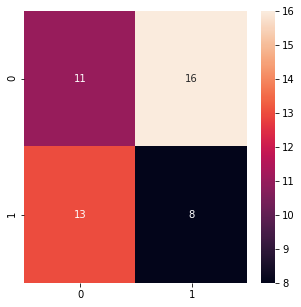

In [ ]:
batch_size = 64  # using beyond 32 crashes the colab notebook(GPU version)
image_size = 256

test_transforms = transforms.Compose([
        transforms.Resize([256 ,256]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_data_dir = '/content/Hemorrahage/val'
test_image_datasets = datasets.ImageFolder( test_data_dir,  test_transforms)
test_dataloaders = torch.utils.data.DataLoader(test_image_datasets, batch_size=batch_size,shuffle=True, num_workers=2)
test_dataset_sizes = len(test_image_datasets)
print(test_dataset_sizes)
test_class_names = test_image_datasets.classes
print(test_class_names)

preds , labels = predict_BYOL_model(Trained_resnet , test_dataloaders)

# Pneumonia model - Resnet18 

Dataset description


5,863 images, 2 categories



- Train data
  - NORMAL - 1341 files
  - PNEUMONIA - 3875 files
- Test data
  - NORMAL - 234 files
  - PNEUMONIA - 390 files
- Val data
   - NORMAL - 8 files
   - PNEUMONIA - 8 files

5216
['NORMAL', 'PNEUMONIA']


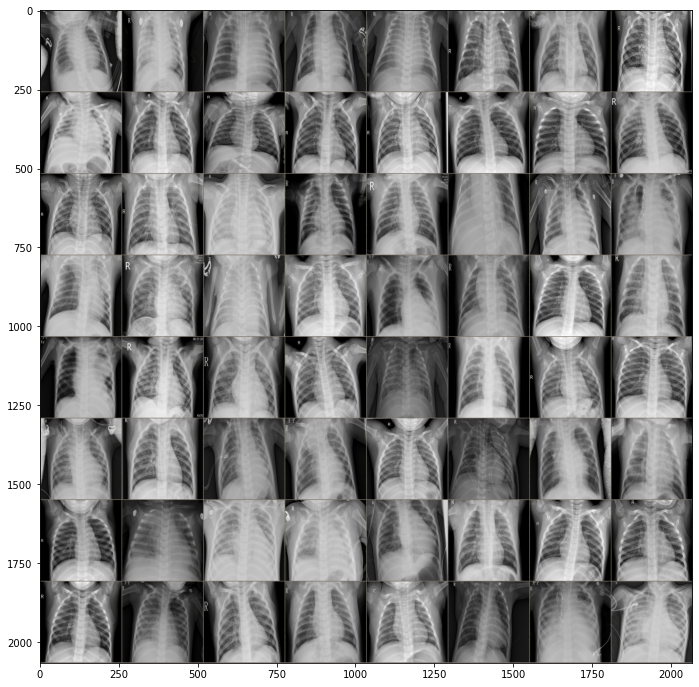

In [ ]:
batch_size = 64  # using beyond 32 crashes the colab notebook(GPU version)
image_size = 256

data_transforms = transforms.Compose([
        transforms.Resize([256 ,256]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = '/content/chest_xray/train/'

image_datasets = datasets.ImageFolder( data_dir,  data_transforms)

dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=batch_size,shuffle=True, num_workers=2)

dataset_sizes = len(image_datasets)

print(dataset_sizes)
class_names = image_datasets.classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


inputs, classes = next(iter(dataloaders))
out = torchvision.utils.make_grid(inputs)
plot_images(out)

In [ ]:
!kaggle datasets download -d amritpal333/byol-pretrained-models
!unzip -q '/content/byol-pretrained-models.zip'

model_wts = torch.load('/content/resnet-18_80-epochs/checkpoints/model.pth')
gen.load_state_dict(torch.load('/content/drive/My Drive/practice/dcgan_g.pth'))
pretrained_resnet.load_state_dict(torch.load('/content/resnet-18_80-epochs/checkpoints/model.pth'), strict=False)
resnet = torch.load('/content/resnet-18_80-epochs/checkpoints/model.pth')

pretrained_resnet = models.resnet18(pretrained=False)
'''num_ftrs = pretrained_resnet.fc.in_features
pretrained_resnet.fc = nn.Linear(num_ftrs, 2)
'''
#model_wts = copy.deepcopy(resnet.state_dict())
#model_wts = torch.load('/content/Pneumonia_resnet_18.pt')

pretrained_resnet.load_state_dict(model_wts)
#Trained_resnet.to(device)

#resnet = models.resnet18(pretrained=True)
#resnet = torch.load('/content/resnet-18_80-epochs/checkpoints/model.pth')



In [ ]:
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)

learner = BYOL(resnet,    image_size = image_size ,    hidden_layer = 'avgpool' ,
               use_momentum = False)
learner = learner.to(device)

#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()

optimizer = torch.optim.Adam(learner.parameters(), lr=3e-4)

model_ft , train_loss = train_BYOL_model(learner, criterion, optimizer, num_epochs= 50)

In [ ]:
torch.save(resnet.state_dict(), './Pneumonia_resnet_18.pt')

Prediction on Test data

In [ ]:
Trained_resnet = models.resnet18(pretrained=False)
num_ftrs = Trained_resnet.fc.in_features
Trained_resnet.fc = nn.Linear(num_ftrs, 2)

#model_wts = copy.deepcopy(resnet.state_dict())
model_wts = torch.load('/content/Pneumonia_resnet_18.pt')

Trained_resnet.load_state_dict(model_wts)
#Trained_resnet.to(device)

<All keys matched successfully>

624
['NORMAL', 'PNEUMONIA']
              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00         1
   PNEUMONIA       0.97      0.60      0.74        47

    accuracy                           0.58        48
   macro avg       0.48      0.30      0.37        48
weighted avg       0.95      0.58      0.72        48



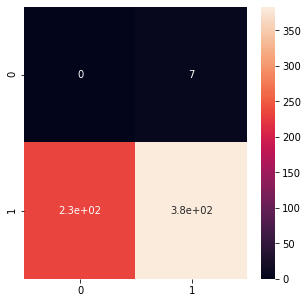

In [ ]:
batch_size = 64  # using beyond 32 crashes the colab notebook(GPU version)
image_size = 256

test_transforms = transforms.Compose([
        transforms.Resize([256 ,256]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_data_dir = '/content/chest_xray/test/'
test_image_datasets = datasets.ImageFolder( test_data_dir,  test_transforms)
test_dataloaders = torch.utils.data.DataLoader(test_image_datasets, batch_size=batch_size,shuffle=True, num_workers=2)
test_dataset_sizes = len(test_image_datasets)
print(test_dataset_sizes)
test_class_names = test_image_datasets.classes
print(test_class_names)

preds , labels = predict_BYOL_model(Trained_resnet , test_dataloaders)

# Supervised learning model - Resnet 18

In [ ]:
epochs = 50
batch_size = 64  # using beyond 32 crashes the colab notebook(GPU version)
image_size = 256

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([256 ,256]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([256 ,256]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#data_dir = '/content/chest_xray'
data_dir = '/content/Hemorrahage'


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)
class_names = image_datasets['train'].classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'train': 5216, 'val': 16}
['NORMAL', 'PNEUMONIA']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def train_supervised_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{} ----------------'.format(epoch, num_epochs - 1))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #outputs = outputs.unsqueeze(2)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    return model

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=3e-4)


model_ft = train_supervised_model(model_ft, criterion, optimizer_ft,
                       num_epochs= 20)

In [ ]:
visualize_model(model_ft)